In [23]:
!wget https://raw.githubusercontent.com/adityarc19/aqi-india/main/city_day.csv

--2024-08-28 16:02:34--  https://github.com/Ayushman-63000/Aqi-prediction/blob/main/delhi_aqi.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘delhi_aqi.csv’

delhi_aqi.csv           [ <=>                ]   1.45M  --.-KB/s    in 0.08s   

2024-08-28 16:02:35 (19.3 MB/s) - ‘delhi_aqi.csv’ saved [1525550]



In [2]:
pip install pandas numpy scikit-learn tensorflow


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset from CSV file
df = pd.read_csv('city_day.csv', parse_dates=['Date'])
name_mapping = {name: idx for idx, name in enumerate(df['City'].unique(), start=1)}
df['City'] = df['City'].map(name_mapping)
df = df.drop(df.columns[-1], axis=1)
df.to_csv('data.csv', index=False)

# Handle missing values - Here, we fill missing values with the median
df.fillna(df.median(), inplace=True)

# Feature engineering - extract date features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek

# Optionally, one-hot encode the 'City' column if you want to include it
df = pd.get_dummies(df, columns=['City'], drop_first=True)
df.fillna(df.median(), inplace=True)

# Define features and target
feature_columns = ['year', 'month', 'day', 'dayofweek'] + [col for col in df.columns if col.startswith('City_')]
target_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

# Filter out rows with no target values
df = df.dropna(subset=target_columns)

X = df[feature_columns]
y = df[target_columns]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(target_columns), activation='linear'))  # Output layer with units for each target variable

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict gas values for a new date and city
# Create a DataFrame with the same columns as the training data
new_data = pd.DataFrame({
    'year': [2024],
    'month': [8],
    'day': [28],
    'dayofweek': [3],
    'City': [1]  # Add columns for all cities, setting to 0 if not present
})

# Ensure all columns in new_data are present in the training data
for column in feature_columns:
    if column not in new_data.columns:
        new_data[column] = 0

# Reorder columns to match the training data
new_data = new_data[feature_columns]

# Normalize and reshape the new date input
new_data_scaled = scaler.transform(new_data)
new_data_scaled = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

# Make prediction
predicted_gas_values = model.predict(new_data_scaled)
print("Predicted gas values:", predicted_gas_values)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1749.2457 - val_loss: 841.7678
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 848.6208 - val_loss: 765.6441
Epoch 3/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 735.3787 - val_loss: 680.3191
Epoch 4/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 687.2521 - val_loss: 634.3437
Epoch 5/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 670.4435 - val_loss: 615.9711
Epoch 6/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 636.5540 - val_loss: 598.5034
Epoch 7/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 651.7137 - val_loss: 586.0150
Epoch 8/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 645.7561 - val_loss: 573.8560
Epoch 9/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 607.6092 - val_loss: 567.4080
Epoch 10/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 615.9767 - val_loss: 556.0498
Epoch 11/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 580.9731 - val_loss: 546.8706
Epoch 12/50
665/66

In [28]:
!wget https://github.com/Ayushman-63000/Aqi-prediction/blob/main/delhi_aqi.csv

--2024-08-28 17:18:02--  https://github.com/Ayushman-63000/Aqi-prediction/blob/main/delhi_aqi.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘delhi_aqi.csv.2’

delhi_aqi.csv.2         [ <=>                ]   1.45M  --.-KB/s    in 0.05s   

2024-08-28 17:18:03 (27.5 MB/s) - ‘delhi_aqi.csv.2’ saved [1525593]



In [50]:
!wget https://raw.githubusercontent.com/Ayushman-63000/Aqi-prediction/main/delhi_aqi.csv

--2024-08-28 17:45:52--  https://raw.githubusercontent.com/Ayushman-63000/Aqi-prediction/main/delhi_aqi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245127 (1.2M) [text/plain]
Saving to: ‘delhi_aqi.csv.6’

delhi_aqi.csv.6     100%[===================>]   1.19M  --.-KB/s    in 0.03s   

2024-08-28 17:45:52 (46.8 MB/s) - ‘delhi_aqi.csv.6’ saved [1245127/1245127]



In [43]:
import pandas as pd

# Load the dataset without parsing dates
df = pd.read_csv('delhi_aqi.csv.5')

# Print column names to verify
print(df.columns)


Index(['date', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'], dtype='object')


Epoch 1/100


<ipython-input-56-386e3b8adcbc>:12: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('delhi_aqi.csv.6', parse_dates=['date'])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5445 - val_loss: 0.5310
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5315 - val_loss: 0.5204
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4878 - val_loss: 0.5143
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5039 - val_loss: 0.5065
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4906 - val_loss: 0.5012
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4694 - val_loss: 0.4949
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4716 - val_loss: 0.4915
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4716 - val_loss: 0.4852
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4519 - val_loss: 0.4820
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5022 - val_loss: 0.4784
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4442 - val_loss: 0.4704
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4591 - val_l

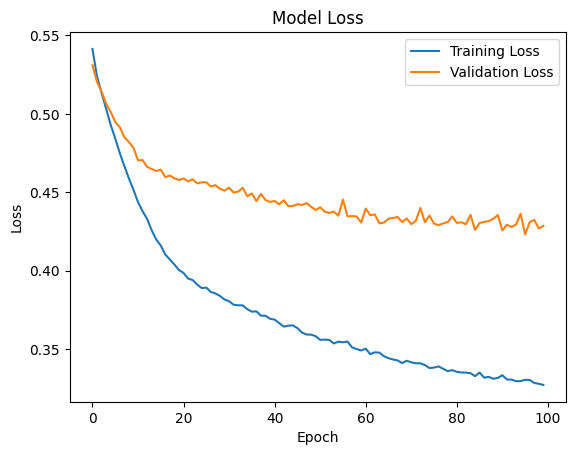

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3439  
Test Loss: 0.34973058104515076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted average gas values for the day:
            co         no        no2         o3        so2      pm2_5  \
0  1053.587158  11.196627  39.196674  20.008274  47.094864  93.244568   

       pm10        nh3  
0  97.98056  10.146416  


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('delhi_aqi.csv.6', parse_dates=['date'])

# Handle missing values
df.fillna(df.median(), inplace=True)

# Set date as index
df.set_index('date', inplace=True)

# Calculate daily averages
daily_avg = df.resample('D').mean()

# Reset index to make date a column again
daily_avg.reset_index(inplace=True)

# Remove any infinite values and drop rows with NaN
daily_avg = daily_avg.replace([np.inf, -np.inf], np.nan).dropna()

# Feature engineering
daily_avg['year'] = daily_avg['date'].dt.year
daily_avg['month'] = daily_avg['date'].dt.month
daily_avg['day'] = daily_avg['date'].dt.day
daily_avg['dayofweek'] = daily_avg['date'].dt.dayofweek

# Define features and target
feature_columns = ['year', 'month', 'day', 'dayofweek']
target_columns = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# Log transform target variables
for col in target_columns:
    daily_avg[col] = np.log1p(daily_avg[col])

# Prepare the data
X = daily_avg[feature_columns]
y = daily_avg[target_columns]

# Normalize the features
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize the target variables
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y)

# Reshape input data for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(target_columns), activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(clipnorm=1.0), loss='mse')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.1, callbacks=[early_stopping],
                    verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict gas values for a new date
new_data = pd.DataFrame({
    'year': [2024],
    'month': [8],
    'day': [28],
    'dayofweek': [2]  # Assuming it's a Wednesday (0 = Monday, 6 = Sunday)
})

# Normalize and reshape the new date input
new_data_scaled = scaler_X.transform(new_data)
new_data_scaled = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

# Make prediction
predicted_gas_values_scaled = model.predict(new_data_scaled)

# Inverse transform the predictions to get actual values
predicted_gas_values = scaler_y.inverse_transform(predicted_gas_values_scaled)

# Reverse the log transformation
predicted_gas_values = np.expm1(predicted_gas_values)

# Create a DataFrame with the results
result_df = pd.DataFrame(predicted_gas_values, columns=target_columns)
print("Predicted average gas values for the day:")
print(result_df)